# 📊 Amazon Sales Analytics Dashboard

### Kaggle Interactive Report

## 📈 Key Performance Indicators


| Metric | Value |
|--------|-------|
| **Total Revenue** | ₹75,402,506 |
| **Total Units Sold** | 114,139 |
| **Avg Revenue/Unit** | ₹660.86 |
| **Avg Profit Margin** | 100.0% |


## 📊 Sales Performance

### 📈 Monthly Sales Trend

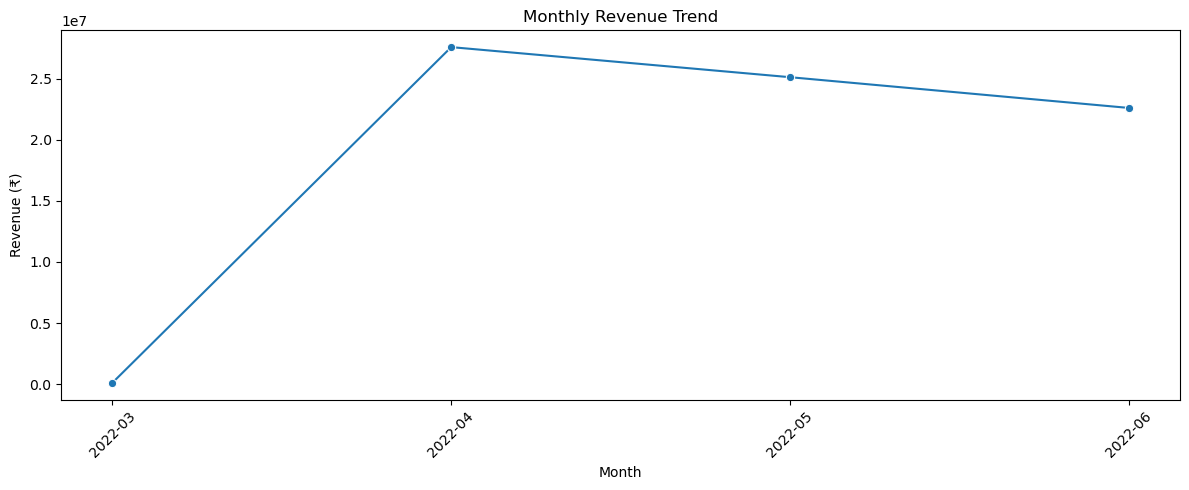

### 📅 Sales by Day of Week

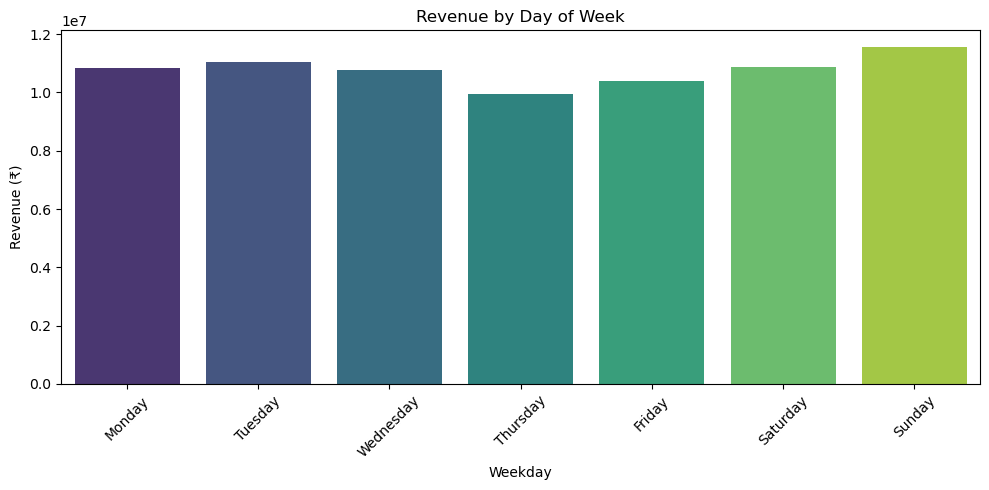

### 🏆 Top Sales Categories

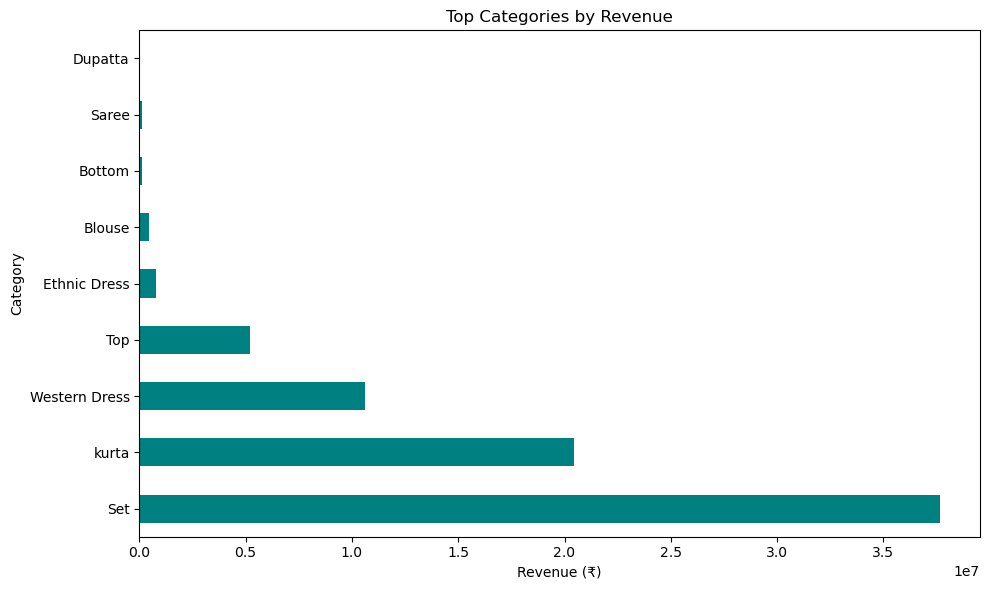

## 📦 Product Analysis

### 🏅 Top & Bottom States by Revenue/Unit

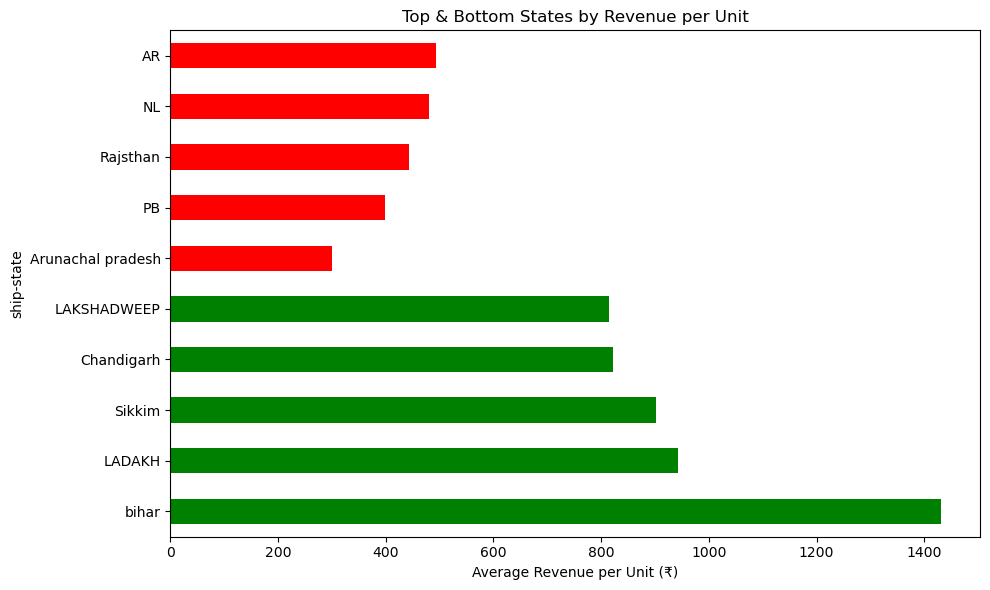

### ⚠️ High-Margin, Understocked SKUs

**Found 456 high-margin, understocked SKUs**

,SKU,Revenue_per_Unit,Qty
1369,J0238-LCD-S,2598.0,1
1371,J0238-LCD-XS,2442.0,1
1372,J0238-LCD-XXXL,1985.0,2
389,J0011-LCD-A-L,1695.0,2
1304,J0228-SKD-L,1694.5,2
1308,J0228-SKD-XS,1669.0,1
414,J0014-LCD-XXL,1648.0,3
1383,J0240-SKD-XL,1621.0,2
1301,J0226-SKD-XS,1593.0,1
1288,J0224-SKD-XL,1593.0,2


### 💰 Profit Margin Distribution

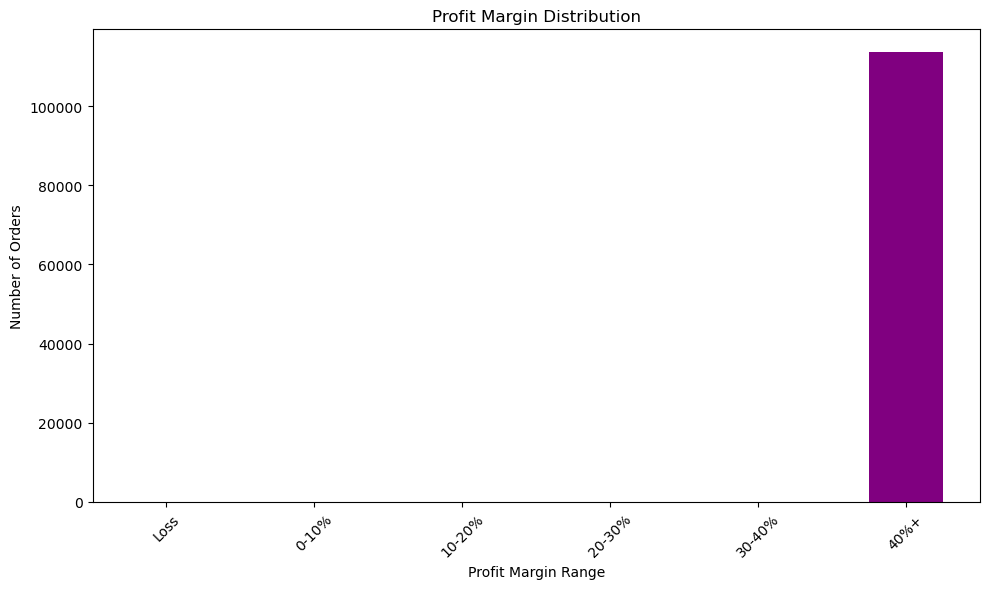

## 👥 Customer Insights

### 🔁 ASIN Repeat Purchases

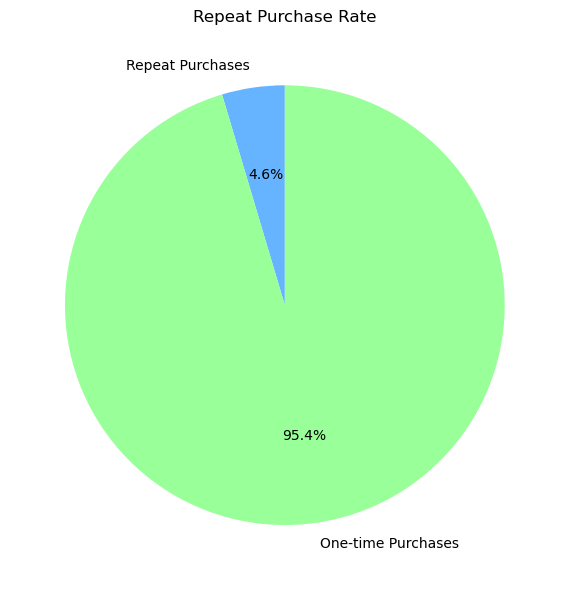

**Repeat ASIN Orders:** 4976

**One-time ASIN Orders:** 102907

### 💎 Top Customers by Lifetime Value

,total_spent,orders,avg_order_value
Customer_Proxy,,,
201301.0_NOIDA,"₹502,625.00",663,₹706.93
122001.0_GURUGRAM,"₹351,401.00",462,₹718.61
560068.0_BENGALURU,"₹325,304.00",452,₹680.55
560037.0_BENGALURU,"₹309,717.00",440,₹650.67
560076.0_BENGALURU,"₹274,475.00",383,₹664.59
560100.0_BENGALURU,"₹258,769.00",369,₹658.45
560043.0_BENGALURU,"₹249,266.00",361,₹657.69
560066.0_BENGALURU,"₹243,667.00",345,₹674.98
500090.0_HYDERABAD,"₹232,548.00",322,₹655.06


## 🌍 Geographical Analysis

### 🗺️ Geographical Sales Distribution

### 🏆 Top Performing States

,ship-state,total_revenue,avg_revenue_per_unit,order_count
27,MAHARASHTRA,"₹12,864,511",₹646.80,18496
22,KARNATAKA,"₹10,153,100",₹652.48,14459
55,TELANGANA,"₹6,642,955",₹658.58,9206
57,UTTAR PRADESH,"₹6,494,393",₹701.81,8709
54,TAMIL NADU,"₹6,241,913",₹610.14,9321
13,DELHI,"₹4,080,019",₹682.16,5599
23,KERALA,"₹3,618,505",₹631.47,5299
59,WEST BENGAL,"₹3,357,170",₹644.77,4910
1,ANDHRA PRADESH,"₹3,049,151",₹641.06,4334
18,HARYANA,"₹2,791,446",₹704.47,3697


---

**Report Generated:** 2025-11-06 19:56

In [11]:
# Amazon Sales Analytics Dashboard for Kaggle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from IPython.display import display, Markdown
import os
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning)

# Dashboard Header
display(Markdown("# 📊 Amazon Sales Analytics Dashboard"))
display(Markdown("### Kaggle Interactive Report"))

# Load and prepare data
def load_data():
    file_path = "kaggle\\input\\unlock-profits-with-e-commerce-sales-data\\Amazon Sale Report.csv"
    
    # Identify problematic columns by loading a sample
    sample = pd.read_csv(file_path, nrows=100)
    mixed_type_cols = [col for col in sample.columns if sample[col].apply(type).nunique() > 1]
    
    # Create dtype specification for problematic columns
    dtype_dict = {col: str for col in mixed_type_cols}
    
    # Read data with explicit dtype for problematic columns
    df = pd.read_csv(file_path, dtype=dtype_dict)
    
    # Data cleaning
    df = df.drop(columns=["index", "Unnamed: 22", "promotion-ids", "fulfilled-by"], errors="ignore")
    df = df.dropna(subset=['Amount', 'Qty'])
    df = df[(df['Qty'] > 0) & (df['Amount'] > 0)]
    
    # Convert date column
    df['Date'] = pd.to_datetime(df['Date'], format="%m-%d-%y", errors='coerce')
    df = df.dropna(subset=['Date'])
    
    # Feature engineering
    df["Revenue_per_Unit"] = df["Amount"] / df["Qty"]
    
    # Handle shipping cost conversion
    if 'ship-service-level' in df.columns:
        # Clean and convert to numeric
        df['ship-service-level'] = (
            df['ship-service-level']
            .astype(str)
            .str.replace(r'[^\d.]', '', regex=True)  # Remove non-numeric characters
        )
        df['ship-service-level'] = pd.to_numeric(df['ship-service-level'], errors='coerce')
        df['ship-service-level'] = df['ship-service-level'].fillna(0)
        
        # Calculate profit margin
        df["Profit_Margin"] = (df["Amount"] - df["ship-service-level"]) / df["Amount"]
    else:
        # Default 20% margin
        df["Profit_Margin"] = 0.2
        
    # Handle infinite values (causes Seaborn warnings)
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Customer proxy and date features
    df['Customer_Proxy'] = df['ship-postal-code'].fillna('').astype(str) + '_' + df['ship-city'].fillna('').astype(str)
    df['Month'] = df['Date'].dt.to_period('M').astype(str)
    df['Month_Num'] = df['Date'].dt.month
    df['Weekday'] = df['Date'].dt.day_name()
    df['Hour'] = df['Date'].dt.hour
    df['Year'] = df['Date'].dt.year
    
    return df

df = load_data()

# Apply default filters
filtered = df.copy()

# Key Metrics
display(Markdown("## 📈 Key Performance Indicators"))

total_revenue = filtered['Amount'].sum()
total_units = filtered['Qty'].sum()
avg_rev_unit = filtered['Revenue_per_Unit'].mean()
avg_margin = filtered['Profit_Margin'].mean()

metrics = f"""
| Metric | Value |
|--------|-------|
| **Total Revenue** | ₹{total_revenue:,.0f} |
| **Total Units Sold** | {total_units:,.0f} |
| **Avg Revenue/Unit** | ₹{avg_rev_unit:.2f} |
| **Avg Profit Margin** | {avg_margin*100:.1f}% |
"""

display(Markdown(metrics))

# -------------------------
# Sales Performance Section
# -------------------------
display(Markdown("## 📊 Sales Performance"))

# Monthly Sales Trend
display(Markdown("### 📈 Monthly Sales Trend"))
monthly = filtered.groupby(['Month', 'Month_Num'])['Amount'].sum().reset_index().sort_values('Month_Num')
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly, x='Month', y='Amount', marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue (₹)")
plt.tight_layout()
plt.show()

# Sales by Day of Week
display(Markdown("### 📅 Sales by Day of Week"))
# Handle NaN values before plotting
weekday_data = filtered.dropna(subset=['Weekday', 'Amount'])
weekday = weekday_data.groupby('Weekday')['Amount'].sum().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday.index, y=weekday.values, palette="viridis")
plt.title("Revenue by Day of Week")
plt.ylabel("Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Top Sales Categories
display(Markdown("### 🏆 Top Sales Categories"))
# Handle NaN values before plotting
category_data = filtered.dropna(subset=['Category', 'Amount'])
top_cats = category_data.groupby('Category')['Amount'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_cats.plot(kind='barh', color='teal')
plt.title("Top Categories by Revenue")
plt.xlabel("Revenue (₹)")
plt.tight_layout()
plt.show()

# -------------------------
# Product Analysis Section
# -------------------------
display(Markdown("## 📦 Product Analysis"))

# Top & Bottom States by Margin
display(Markdown("### 🏅 Top & Bottom States by Revenue/Unit"))
# Handle NaN values before plotting
state_data = filtered.dropna(subset=['ship-state', 'Revenue_per_Unit'])
state_rev = state_data.groupby("ship-state")["Revenue_per_Unit"].mean()
top_5 = state_rev.nlargest(5)
bottom_5 = state_rev.nsmallest(5)
combined = pd.concat([top_5, bottom_5])

plt.figure(figsize=(10, 6))
combined.plot(kind='barh', color=['green']*5 + ['red']*5)
plt.title("Top & Bottom States by Revenue per Unit")
plt.xlabel("Average Revenue per Unit (₹)")
plt.tight_layout()
plt.show()

# High-Margin & Understocked SKUs
display(Markdown("### ⚠️ High-Margin, Understocked SKUs"))
# Handle NaN values before calculation
sku_data = filtered.dropna(subset=['SKU', 'Revenue_per_Unit', 'Qty'])
sku_sum = sku_data.groupby("SKU").agg({"Revenue_per_Unit":"mean","Qty":"sum"}).reset_index()
high_m = sku_sum["Revenue_per_Unit"].quantile(0.75)
low_q = sku_sum["Qty"].quantile(0.25)
sku_alerts = sku_sum[(sku_sum["Revenue_per_Unit"] >= high_m) & (sku_sum["Qty"] <= low_q)]

display(Markdown(f"**Found {len(sku_alerts)} high-margin, understocked SKUs**"))
display(sku_alerts.sort_values("Revenue_per_Unit", ascending=False).head(10))

# Profit Margin Analysis
display(Markdown("### 💰 Profit Margin Distribution"))
# Handle NaN and infinite values
margin_data = filtered.dropna(subset=['Profit_Margin'])
margin_data = margin_data[np.isfinite(margin_data['Profit_Margin'])]
margin_bins = pd.cut(margin_data['Profit_Margin'], bins=[-1, 0, 0.1, 0.2, 0.3, 0.4, 1], 
                     labels=["Loss", "0-10%", "10-20%", "20-30%", "30-40%", "40%+"])
margin_dist = margin_bins.value_counts().sort_index()

plt.figure(figsize=(10, 6))
margin_dist.plot(kind='bar', color='purple')
plt.title("Profit Margin Distribution")
plt.xlabel("Profit Margin Range")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# Customer Insights Section
# -------------------------
display(Markdown("## 👥 Customer Insights"))

# Customer Repeat Purchase
display(Markdown("### 🔁 ASIN Repeat Purchases"))
# Handle NaN values
repeat_data = filtered.dropna(subset=['Customer_Proxy', 'ASIN', 'Order ID'])
asin_orders = repeat_data.groupby(['Customer_Proxy','ASIN'])['Order ID'].nunique().reset_index(name='count')
repeat = (asin_orders['count']>1).sum()
one_time = (asin_orders['count']==1).sum()

plt.figure(figsize=(8, 6))
plt.pie([repeat, one_time], labels=['Repeat Purchases', 'One-time Purchases'], 
        autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title("Repeat Purchase Rate")
plt.tight_layout()
plt.show()

display(Markdown(f"**Repeat ASIN Orders:** {repeat}"))
display(Markdown(f"**One-time ASIN Orders:** {one_time}"))

# Customer Value Analysis
display(Markdown("### 💎 Top Customers by Lifetime Value"))
# Handle NaN values
customer_data = filtered.dropna(subset=['Customer_Proxy', 'Amount'])
customer_value = customer_data.groupby('Customer_Proxy').agg(
    total_spent=('Amount', 'sum'),
    orders=('Order ID', 'nunique'),
    avg_order_value=('Amount', 'mean')
).sort_values('total_spent', ascending=False).head(10)

display(customer_value.style.format({
    'total_spent': '₹{:,.2f}',
    'avg_order_value': '₹{:,.2f}'
}))

# -------------------------
# Geographical Analysis Section
# -------------------------
display(Markdown("## 🌍 Geographical Analysis"))

# Prepare data for map
geo_data = filtered.dropna(subset=['ship-state'])
geo_data = geo_data.groupby('ship-state').agg(
    total_revenue=('Amount', 'sum'),
    avg_revenue_per_unit=('Revenue_per_Unit', 'mean'),
    order_count=('Order ID', 'nunique')
).reset_index()

# Create interactive map
display(Markdown("### 🗺️ Geographical Sales Distribution"))
try:
    fig = px.choropleth(
        geo_data,
        geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        featureidkey='properties.ST_NM',
        locations='ship-state',
        color='total_revenue',
        color_continuous_scale='Blues',
        hover_data=['avg_revenue_per_unit', 'order_count'],
        labels={'total_revenue':'Total Revenue'},
        title="Revenue by State"
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()
except Exception as e:
    display(Markdown(f"⚠️ **Map Error:** {str(e)}"))
    display(Markdown("Showing top states table instead"))

# State performance table
display(Markdown("### 🏆 Top Performing States"))
top_states = geo_data.sort_values('total_revenue', ascending=False).head(10)
display(top_states.style.format({
    'total_revenue': '₹{:,.0f}',
    'avg_revenue_per_unit': '₹{:,.2f}'
}).background_gradient(cmap='Blues', subset=['total_revenue']))

# Footer
display(Markdown("---"))
display(Markdown(f"**Report Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}"))